In [ ]:
# 3/20 check point 구현 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==1.15
!pip install keras==2.2.4
!pip install keras_tqdm

In [ ]:
#!pip install tensorflow==1.15.0
import tensorflow as tf
import keras
print(tf.__version__) # 1,15,0
print(keras.__version__) # 2.2.4

1.15.0
2.2.4


Using TensorFlow backend.


In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf

# Set some parameters # 3/23 : 256,512 -> (690,1600)(X) , (688,1600)(O), (512,1024)
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_CHANNELS = 3

# 파일 경로 설정
drive_path='/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/'
TRAIN_PATH = drive_path # drive_path='/content/sample_data/'

TRAIN_PATH_IMG=TRAIN_PATH+'train_images/train_images_v1/'
TRAIN_PATH_MASK=TRAIN_PATH+'train_masks/train_masks_v1/'

VAL_PATH_IMG=TRAIN_PATH+'val_images/val_images_v1/'
VAL_PATH_MASK=TRAIN_PATH+'val_masks/val_masks_v1/'


TEST_PATH = drive_path
TEST_PATH_IMG=TEST_PATH+'test_images/' # 예측할 데이터 파일



In [ ]:
# Get train and test IDs
# train images와 mask를 정렬해서 각각 대비되는지 확인
'''
next의 [0]번 결과는 특정 디렉토리의 위치 값을 저장
next의 [1]번 결과는 특정 디렉토리의 모든 하위 디렉토리 리스트를 저장
next의 [2]번 결과는 특정 디렉토리에 포함된 모든 파일 리스트를 저장
'''
test_ids_img = next(os.walk(TEST_PATH_IMG))[2] 
test_ids_img.sort()

train_ids_img = next(os.walk(TRAIN_PATH_IMG))[2]
train_ids_img.sort()
train_ids_mask = next(os.walk(TRAIN_PATH_MASK))[2]
train_ids_mask.sort()

val_ids_img = next(os.walk(VAL_PATH_IMG))[2]
val_ids_img.sort()
val_ids_mask = next(os.walk(VAL_PATH_MASK))[2]
val_ids_mask.sort()

In [ ]:
print(len(train_ids_img))
print(len(train_ids_mask))
print(len(val_ids_img))
print(len(val_ids_mask))

836
836
25
25


In [ ]:
for n in range(len(val_ids_img)):
    if(n<10):
        print(n, ":",val_ids_img[n],',',val_ids_mask[n])
    

0 : 11_1_057.jpg , 11_1_057_mask.jpg
1 : 11_1_058.jpg , 11_1_058_mask.jpg
2 : 12_35_010.jpg , 12_35_010_mask.jpg
3 : 12_35_011.jpg , 12_35_011_mask.jpg
4 : 1_2_009.jpg , 1_2_009_mask.jpg
5 : 1_2_010.jpg , 1_2_010_mask.jpg
6 : 1_2_012.jpg , 1_2_012_mask.jpg
7 : 21_1_007.jpg , 21_1_007.jpg_gray_mask.jpg
8 : 21_1_008.jpg , 21_1_008.jpg_gray_mask.jpg
9 : 21_1_009.jpg , 21_1_009.jpg_gray_mask.jpg


In [ ]:
for n in range(len(train_ids_img)):
    if(n<10):
        print(n, ":",train_ids_img[n],',',train_ids_mask[n])
    

0 : 01_001.jpg , 01_001_mask.jpg
1 : 02_002.jpg , 02_002_mask.jpg
2 : 03_003.jpg , 03_003_mask.jpg
3 : 04_004.jpg , 04_004_mask.jpg
4 : 05_005.jpg , 05_005_mask.jpg
5 : 06_006.jpg , 06_006_mask.jpg
6 : 07_007.jpg , 07_007_mask.jpg
7 : 08_008.jpg , 08_008_mask.jpg
8 : 09_009.jpg , 09_009_mask.jpg
9 : 100_100.jpg , 100_100_mask.jpg


In [ ]:
# 검증데이터 전처리
X_val = np.zeros((len(val_ids_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_val = np.zeros((len(val_ids_img), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n in tqdm(range(len(val_ids_img)), total=len(val_ids_img)): # tqdm : for 문 진행바 보여줌
    path_img = VAL_PATH_IMG # 'val_images/'
    path_mask = VAL_PATH_MASK
    img_id_=val_ids_img[n] # images
    mask_id_=val_ids_mask[n]
    
    
    img = imread(path_img + img_id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_val[n] = img
    mask_ = imread(path_mask + mask_id_,as_gray=True)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)
    Y_val[n] = mask_

Getting and resizing train images and masks ... 


100%|██████████| 25/25 [00:16<00:00,  1.48it/s]


In [ ]:
# Get and resize train images and masks
    # 여기서 오류가 날때 폴더에 숨김파일 thumbs.db가 있는지 확인해주세요. 미리보기 저장 파일로 숨김파일로
    # 있을 수 있습니다. 폴더에서 숨김파일 항목 체크하면 확인할 수 있습니다.

X_train = np.zeros((len(train_ids_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids_img), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n in tqdm(range(len(train_ids_img)), total=len(train_ids_img)): # tqdm : for 문 진행바 보여줌
    path_img = TRAIN_PATH_IMG # 'train_images/'
    path_mask = TRAIN_PATH_MASK
    img_id_=train_ids_img[n] # images
    mask_id_=train_ids_mask[n]
    
    
    img = imread(path_img + img_id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask_ = imread(path_mask + mask_id_,as_gray=True)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)
    Y_train[n] = mask_

# Get and resize test images
X_test = np.zeros((len(test_ids_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for  n in tqdm(range(len(test_ids_img)), total=len(test_ids_img)):
    path_img = TEST_PATH_IMG
    #path_mask = TEST_PATH_MASK
    img_id_=test_ids_img[n]
    #mask_id_=test_ids_mask[n]
    
    img = imread(path_img + img_id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 836/836 [09:27<00:00,  1.47it/s]

Getting and resizing test images ... 



100%|██████████| 16/16 [00:05<00:00,  3.00it/s]

Done!


In [ ]:
# Check if training data looks all right
tx = random.randint(0, len(val_ids_img))
imshow(X_val[tx])
plt.show()
imshow(np.squeeze(Y_val[tx]))
plt.show()

In [ ]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids_img))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [ ]:
# Define IoU metric
'''
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
'''
# loss function
smooth = 1.
def dice_coef(y_true, y_pred):
	y_true_f = K.flatten(y_true)
	y_pred_f = K.flatten(y_pred)
	intersection = K.sum(y_true_f * y_pred_f)
	return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
	return 1-dice_coef(y_true, y_pred)



In [ ]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

model.summary()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = dict(
        #featurewise_center = True,
        #featurewise_std_normalization=True,
        rotation_range=30, #이미지 회전 범위 (degrees)
        width_shift_range=0.2, #그림을 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위 (원본 가로, 세로 길이에 대한 비율 값)
        height_shift_range=0.2,
        rescale=1./255, #flow 로 변형된 이미지 확인할때 주석처리
        zoom_range=0.1
        )

image_datagen = ImageDataGenerator(datagen)
mask_datagen = ImageDataGenerator(datagen)
validation_image_datagen = ImageDataGenerator(datagen)
validation_mask_datagen = ImageDataGenerator(datagen)

seed = 1
seed2 = 2
#image_datagen.fit(X_train, augment=True, seed=seed)
#mask_datagen.fit(Y_train, augment=True, seed=seed)
#validation_image_datagen.fit(X_val,augment=True, seed = seed)
#validation_mask_datagen.fit(Y_val,augment=True, seed = seed)


In [ ]:
TRAIN_PATH_IMG = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/train_images/'
TRAIN_PATH_MASK = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/train_masks/'
VAL_PATH_IMG = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/val_images/'
VAL_PATH_MASK = '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/val_masks/'

image_generator = image_datagen.flow_from_directory(
    TRAIN_PATH_IMG,
    target_size = (512,256),
    color_mode='rgb',
     class_mode=None,
     batch_size = 4,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    TRAIN_PATH_MASK,
    target_size = (512,256),
    color_mode='grayscale',
     class_mode=None,
     batch_size = 4,
    seed=seed)

validation_image_generator = validation_image_datagen.flow_from_directory(
		VAL_PATH_IMG,
		target_size=(512,256),
		color_mode='rgb',
        class_mode=None,
		seed=seed2,
        batch_size = 5)
		

validation_mask_generator = validation_mask_datagen.flow_from_directory(
		VAL_PATH_MASK,
		target_size=(512,256),
		color_mode='grayscale',
        class_mode=None,
		seed=seed2,
        batch_size = 5)
		
train_generator = zip(image_generator, mask_generator)
validation_generator = zip(validation_image_generator,validation_mask_generator)

Found 836 images belonging to 1 classes.
Found 836 images belonging to 1 classes.
Found 25 images belonging to 1 classes.
Found 25 images belonging to 1 classes.


In [ ]:
MODEL_SAVE_FOLDER_PATH = drive_path+'model_checkPoint_test/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
model_path = MODEL_SAVE_FOLDER_PATH+'{epoch:02d}-{val_loss:.4f}.h5'


In [ ]:
from keras.callbacks import TensorBoard

tensorboard_path = os.path.join('/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/mytensorboard','V3')
if not os.path.exists(tensorboard_path):
	os.mkdir(tensorboard_path)


"\ntensorboard_path = os.path.join('/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/mytensorboard','V3')\nif not os.path.exists(tensorboard_path):\n\tos.mkdir(tensorboard_path)\n"

In [ ]:
tb_hist = TensorBoard(log_dir= '/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/graph', 
                      histogram_freq=0, # 통상적으로 써줌
                      write_graph=True, 
                      write_images=True) 

In [ ]:
# Fit model
#earlystopper = EarlyStopping(patience=100, verbose=1)
# monitor='loss'
#checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_loss', save_best_only=True, save_weights_only= True)
checkpointer = ModelCheckpoint(filepath=model_path, verbose=1, save_weights_only= True,period=15)
#results = model.fit(X_train, Y_train, validation_split=0.02, batch_size=4, epochs=300
#                    , callbacks=[checkpointer])

In [ ]:
from tensorboardcolab import *
tbc=TensorBoardColab(startup_waiting_time=30)
#summary_writer = tbc.get_writer()

Wait for 30 seconds...
TensorBoard link:
http://467b67a0.ngrok.io


In [ ]:

#model.load_weights('/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/model_checkPoint/10--97.4605.h5') #<- 예측할때 주석풀고 실행
model.fit_generator(
    train_generator,
    steps_per_epoch=209, # sample_수 836/ batch_size : 4
    epochs=1000,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=5, # sample_수 25/ batch_size : 5 
    callbacks=[checkpointer,TensorBoardColabCallback(tbc)])

Epoch 1/1000


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 37/209 [====>.........................] - ETA: 1:26 - loss: -0.5851 - dice_coef: 1.5851

In [ ]:
# 다시 훈련 시킬때 실행 weight파일 이름 넣어야함 
model.load_weights('/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/model_checkPoint/404--0.9505.h5') #loss 
# 에포크 124 + 124

In [ ]:
# Fit model
#earlystopper = EarlyStopping(patience=100, verbose=1)
#checkpointer = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True, save_weights_only= True)
checkpointer = ModelCheckpoint(filepath=model_path, verbose=1, save_weights_only= True,period=15)
#results = model.fit(X_train, Y_train, validation_split=0.02, batch_size=4, epochs=300
#                    , callbacks=[earlystopper,checkpointer])

In [ ]:
# Predict on train, val and test

model.load_weights('/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data_4-16/model_checkPoint/404--0.9505.h5') #<- 예측할때 주석풀고 실행
#preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))


16/16 [==============================] - 0s 9ms/step


In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

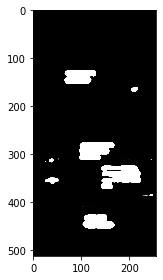

(512, 256, 1)


In [ ]:
#ix = random.randint(0, len(X_test))

imshow(np.squeeze(preds_test[ix]))
plt.show()
print(preds_test[ix].shape)
#imshow(np.squeeze(preds_test_t[1])*255)
#imshow(np.squeeze(preds_test_t[2]))
#plt.show()
#print(preds_test_t[ix].shape)


In [ ]:
img = np.squeeze(preds_test_t[1])*255
img.shape

(512, 256)

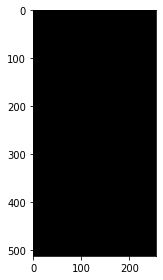

In [ ]:
#imshow(preds_test[ix])
#plt.show()
#print(preds_test[ix].shape)
#imshow(np.squeeze(preds_test_t[4]*255))
imshow(np.squeeze(preds_test_t[0]))
plt.show()

In [ ]:
# 모델 돌려보기 사진 저장 경로 설정 필요
import cv2  # *255는 위에 mask범위를 보면 0~1인데 마스킹된 부분이 1 -> 노랑으로 되있어서 255를 곱해준다.
cv2.imwrite(drive_path+'predict_images/epoch548v1_predict.jpg',(preds_test_upsampled[ix]))

True

In [ ]:
len(preds_test_t)

6

In [ ]:
preds_test.shape

(16, 512, 256, 1)